In this notebook, we will attempt to apply another type of text-data preprocessing viz. TF-IDF based vectorization. We will also try a simple neural network model to see if we can improve the baseline score. 

We could have gone for sequence models by incorporating word embeddings but the corpus that we are dealing with is not very large and experiments say that in these cases n-gram models perform better. Another reason behind not using word embeddings is embedding relationships are learned in dense space, and this happens best over many samples (i.e. a very very large corpora).

In [2]:
#Dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

from keras import backend as K

import tensorflow as tf 
# import tf.keras

# Importing the keras libraries from tensorflow package for maintaining same library use for loading the saved model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline
# We are using tensorflow version 2.0.0-beta0, to allow tensorflow some operations of v1
import tensorflow.compat.v1 as tfv1
tfv1.disable_v2_behavior()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

During our previous experiments, we serialized the shorter versions of the train and test sets. Let's load them.

In [3]:
new_train_frame = pd.read_csv('./GoodData/final_data_extended_labeledPhase1 - final_data_extended_labeledPhase2.csv')
# new_test_frame = pd.read_csv('new_test_frame.csv', encoding = "ISO-8859-1")

In [4]:
new_train_frame.drop(new_train_frame[new_train_frame['label'].isna()==True].index, axis=0, inplace=True)

In [5]:
new_train_frame.head()

,comment,label,articleName
0,"Thank you for this tutorial , it is simple to ...",0.0,Python List Comprehension Tutorial
1,Good,0.0,Python List Comprehension Tutorial
2,In the 'filter' section the given code returns...,0.0,Python List Comprehension Tutorial
3,"Hi there! Thanks for the tutorial, much appre...",0.0,Python List Comprehension Tutorial
4,It's lovely!!!!easy to understand.........than...,0.0,Python List Comprehension Tutorial


## First let's confirm with the class label's uniqueness

In [6]:
np.unique(new_train_frame['label'])

array([0., 1.])

## Now let's check on the class distribution

In [7]:
classSpam = new_train_frame[new_train_frame.label == 1.0]
classNonSpam = new_train_frame[new_train_frame.label == 0.0]

In [13]:
classSpam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 23 to 591
Data columns (total 3 columns):
comment        111 non-null object
label          111 non-null float64
articleName    111 non-null object
dtypes: float64(1), object(2)
memory usage: 3.5+ KB


In [11]:
classNonSpam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497 entries, 0 to 609
Data columns (total 3 columns):
comment        497 non-null object
label          497 non-null float64
articleName    497 non-null object
dtypes: float64(1), object(2)
memory usage: 15.5+ KB


#### So the distribution is 111:497 for spam vs non-spam, abbreviates to 1:5. 

## Splitting into train and validation sets (80:20) - 

In [14]:


X_train, X_valid, y_train, y_valid = train_test_split(new_train_frame['comment'], new_train_frame['label'], \
                                                    test_size=0.2, random_state=42)

## Data preprocessing with TF-IDF vectorization - 

We can write utility functions for this which in turns gives our code a modular approach. 

In [15]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """
    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)


    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)
    
    # Show extracted features
    cache = {}
    cache['extractedFeatures'] = vectorizer.get_feature_names()
    
    return x_train, x_val, vectorizer, cache

## Building an MLP model

We are dealing with a binary classification problem so the activation function for the output layer of the network will be `sigmoid` as it will give us the class probabilities which we can eventually convert to discrete classes. 

The following function `get_last_layer_units_and_activation()` is responsible for - 
* Determining the activation function for the output layer.
* Number of units to be present in the output layer. 

The function can also be extended to multinomial classification tasks as well (where `softmax` activation function is used in the last layer). 

In [16]:
def get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

The following method builds us a feed-forward network. 

In [17]:


def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

`train_ngram_model()` function helps to train and validate our shallow network.  

## Before going for training adding F1-score custom metrics for evalutaion

In [18]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:


def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=3,
                      units=64,
                      dropout_rate=0.2):
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Specify the number of classes.
    num_classes = 2

    # Vectorize texts.
    x_train, x_val, vectorizer, cache = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Instantiate the model
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    loss = 'binary_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc', f1])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    # Tensorboard callback for debugging purpose
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2), tf.keras.callbacks.TensorBoard(log_dir='./logs')]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('zs_mlp_model.h5')
    return history

<b>A note on the model configuration choices</b>:
* **Dropout layers**: For reducing overfitting. Its value is set 0.2 which means that 20% of the input data will be randomly chosen and excluded from successive activations. This [blog](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/) provides a gentle introduction to dropout regularization. 
* **Loss function**: We used `binary_crossentropy` as our loss function which is a pretty standard one when it comes to binary classification. It is also convex in nature which in turn helps the optimization algorithm in a faster convergence. 
* **Adam optimizer**: Stochastic gradient descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.Whereas in Adam, a learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds.The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients.

## Training and evaluating the MLP model

#### Preparing the data for fitting it to a feed-forward network - 

In [22]:
data = ((list(X_train), np.array(y_train)), (list(X_valid), np.array(y_valid)))

#### Training a feed-forward networks - 

In [23]:
x_train, x_val, vectorizer, cache = ngram_vectorize(
        X_train, y_train, X_valid)

## Let's check the tokens

In [24]:
cache

{'extractedFeatures': ['041',
  '041 8324',
  '10',
  '100',
  '11',
  '14',
  '15',
  '20',
  '2018',
  '2019',
  '24',
  '24 support',
  '24 to',
  '2d',
  '30',
  '32',
  '44',
  '44 800',
  '462',
  '462 in',
  '50',
  '64',
  '800',
  '800 041',
  '8324',
  '888',
  '8884800288',
  '8884800288 uk',
  '98',
  '__init__',
  '__init__ self',
  'able',
  'able to',
  'about',
  'about how',
  'about it',
  'about the',
  'above',
  'access',
  'account',
  'accounting',
  'accuracy',
  'achieve',
  'across',
  'across the',
  'active',
  'active 24',
  'actually',
  'add',
  'added',
  'adding',
  'address',
  'aditya',
  'advance',
  'advice',
  'advice me',
  'after',
  'after the',
  'again',
  'against',
  'age',
  'ahead',
  'ai',
  'airlines',
  'airlines customer',
  'airlines reservations',
  'alexisp',
  'algorithm',
  'algorithms',
  'all',
  'all thanks',
  'all the',
  'all these',
  'allows',
  'almost',
  'along',
  'alot',
  'already',
  'already have',
  'also',
  'als

In [25]:
h = train_ngram_model(data,\
                      learning_rate=1e-3,\
                      epochs=1000,\
                      batch_size=128,\
                      layers=3,\
                      units=64,\
                      dropout_rate=0.7)

W0902 21:59:20.576940 11604 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0902 21:59:20.617977 11604 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0902 21:59:20.656870 11604 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0902 21:59:20.763546 11604 deprecation.py:323] From d:\programfiles\anaconda\envs\nlp\lib\site-packages\tensorflow\python\ops\nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 486 samples, validate on 122 samples
Epoch 1/1000
486/486 - 0s - loss: 0.6662 - acc: 0.7078 - f1: 0.1075 - val_loss: 0.6782 - val_acc: 0.7787 - val_f1: 0.0000e+00
Epoch 2/1000
486/486 - 0s - loss: 0.6552 - acc: 0.7387 - f1: 0.0247 - val_loss: 0.6658 - val_acc: 0.7787 - val_f1: 0.0000e+00
Epoch 3/1000
486/486 - 0s - loss: 0.6340 - acc: 0.8189 - f1: 0.0677 - val_loss: 0.6515 - val_acc: 0.7787 - val_f1: 0.0000e+00
Epoch 4/1000
486/486 - 0s - loss: 0.6155 - acc: 0.8148 - f1: 0.0179 - val_loss: 0.6350 - val_acc: 0.7787 - val_f1: 0.0000e+00
Epoch 5/1000
486/486 - 0s - loss: 0.5997 - acc: 0.8251 - f1: 0.0263 - val_loss: 0.6158 - val_acc: 0.7787 - val_f1: 0.0000e+00
Epoch 6/1000
486/486 - 0s - loss: 0.5721 - acc: 0.8272 - f1: 0.0000e+00 - val_loss: 0.5944 - val_acc: 0.7787 - val_f1: 0.0000e+00
Epoch 7/1000
486/486 - 0s - loss: 0.5428 - acc: 0.8272 - f1: 0.0000e+00 - val_loss: 0.5708 - val_acc: 0.7787 - val_f1: 0.0000e+00
Epoch 8/1000
486/486 - 0s - loss: 0.5278 - acc: 0.8272 - f1: 0.0

486/486 - 0s - loss: 0.1915 - acc: 0.9156 - f1: 0.6794 - val_loss: 0.3032 - val_acc: 0.8852 - val_f1: 0.6500
Validation accuracy: 0.8852459192276001, loss: 0.303184449672699


    The validation accuracy has increased to a good extent with a shallow net. 

#### Plotting and summarization of loss and accuracy - 

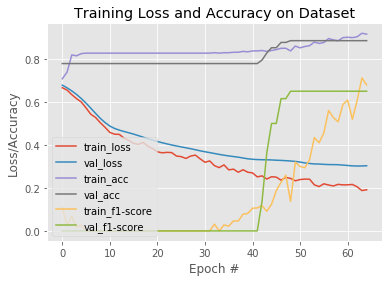

In [28]:
# Plot the training loss and accuracy.

 
# Plot
N = len(h['loss'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), h["loss"], label="train_loss")
plt.plot(np.arange(0, N), h["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h["acc"], label="train_acc")
plt.plot(np.arange(0, N), h["val_acc"], label="val_acc")
plt.plot(np.arange(0, N), h["f1"], label="train_f1-score")
plt.plot(np.arange(0, N), h["val_f1"], label="val_f1-score")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

## Deriving the classification report with the help of the serialized model

We have the model serialized in a .h5 file. We load it up and use it for evaluation and for making predictions.

In [29]:
# Loading the model

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        model = load_model('zs_mlp_model.h5', custom_objects= {'f1': f1}) # We serialized the weights of the feed-forward network

W0902 22:01:25.185992 11604 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0902 22:01:25.208930 11604 deprecation.py:506] From d:\programfiles\anaconda\envs\nlp\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0902 22:01:25.236855 11604 nn_ops.py:4220] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


We used `CustomObjectScope` to load up the `model.h5` file since there were compatibility issues. The `CustomObjectScope` needs an instance to be passed hence the use of the `gloroth_uniform` initializer. It does not have any other special purpose. 

Stackoverflow thread referred for this: https://stackoverflow.com/questions/53183865/unknown-initializer-glorotuniform-when-loading-keras-model

In [30]:


_, validation_vectors, _, cache = ngram_vectorize(
        list(X_train), np.array(y_train), list(X_valid))
valid_preds = model.predict_classes(validation_vectors)
print(classification_report(y_valid, valid_preds))

              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        95
         1.0       1.00      0.48      0.65        27

    accuracy                           0.89       122
   macro avg       0.94      0.74      0.79       122
weighted avg       0.90      0.89      0.87       122



In [32]:
confusion_matrix(y_valid, valid_preds)

array([[95,  0],
       [14, 13]], dtype=int64)

In [33]:
print('No. of spams in validation dataset: {}, No. of non-spams in vaidation dataset: {}'.format(y_valid.tolist().count(1.0), y_valid.tolist().count(0.0)))

No. of spams in validation dataset: 27, No. of non-spams in vaidation dataset: 95


In [35]:
testData = vectorizer.transform(np.array(['Get personalized training at Chennai, visit www.chennaimltraining.com']))
model.predict_classes(testData)

array([[1]])

In [ ]:
tf.keras.utils.plot_model(model,to_file='model.png',show_shapes=True, show_layer_names=True)

![](model.png)

### Further considerations - 

* Hyperparameter tuning.
* Prediction ensembles. 
* Build a simple REST API of the shallow net so that it can be deployed in production. 